<a href="https://colab.research.google.com/github/MayaHayat/Intel_Classification/blob/main/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intel Image Classification

By Aviya Oren and Maya Hayat

This Data contains around 25k images of size 150x150 distributed under 6 categories.
1. 'buildings'
2. 'forest'
3. 'glacier'
4. 'mountain'
5. 'sea'
6. 'street'

In [5]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import random

import cv2
import imghdr
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

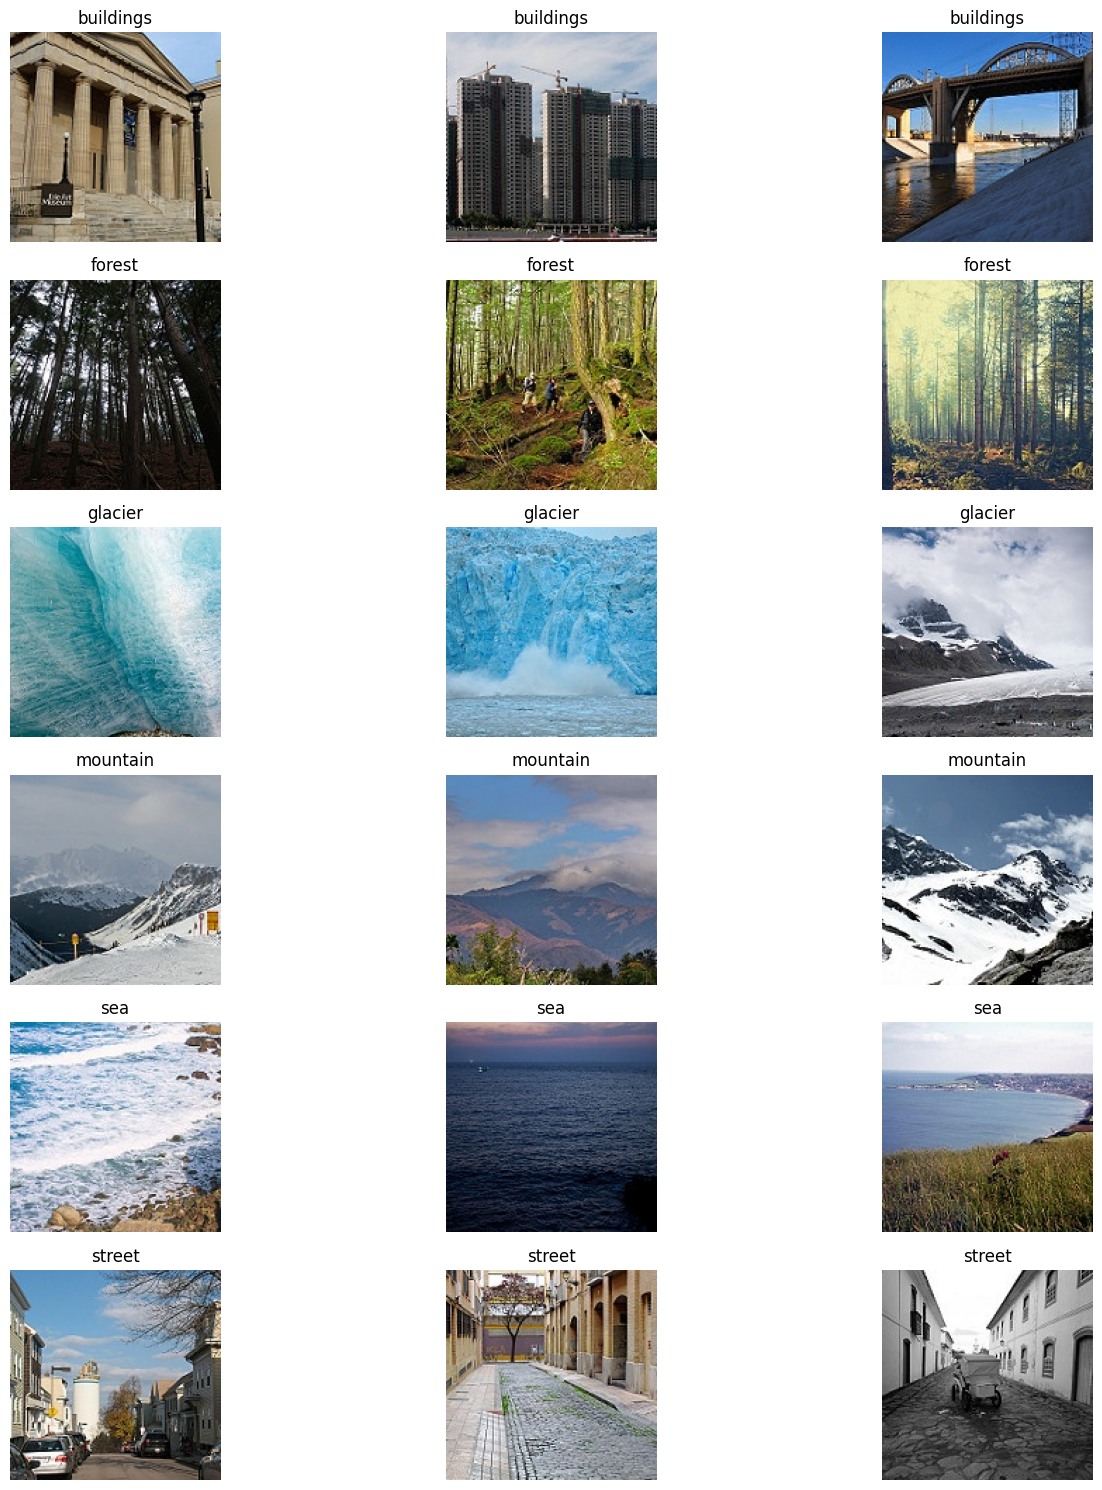

In [3]:
# Path to the directory containing the images
base_directory = '/content/drive/MyDrive/IntelClassification/seg_train'

# Categories
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Display three random images for each category
fig, axs = plt.subplots(len(categories), 3, figsize=(15, 15))

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    random_images = random.sample(image_files, 3)

    for j, image_file in enumerate(random_images):
        image_path = os.path.join(category_directory, image_file)
        image = mpimg.imread(image_path)
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(category)

plt.tight_layout()
plt.show()


In [17]:
data_directory = '/content/drive/MyDrive/IntelClassification/seg_train'

In [18]:
test_data = '/content/drive/MyDrive/IntelClassification/seg_test'

In [19]:
os.listdir(data_directory)

['forest', 'buildings', 'street', 'sea', 'mountain', 'glacier']

In [20]:
os.listdir(test_data)

['sea', 'mountain', 'glacier', 'buildings', 'street', 'forest']

In [21]:
# According to Kaggle the original size if 150*150, therefore we want to keep it as is
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/IntelClassification/seg_train', image_size = (150,150), batch_size=128)

Found 14034 files belonging to 6 classes.


In [22]:
test = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/IntelClassification/seg_test', image_size = (150,150), batch_size=128)

Found 3020 files belonging to 6 classes.


In [23]:
data_iterator = data.as_numpy_iterator()
test_iterator = test.as_numpy_iterator()

In [24]:
batch = data_iterator.next()

In [25]:
batch_test = test_iterator.next()

In [26]:
# where the first batch is our data and the second is the labels
len(batch),len(batch_test)

(2, 2)

In [27]:
batch[0].shape

(128, 150, 150, 3)

In [14]:
batch_test[0].shape

(128, 150, 150, 3)

In [11]:
batch[1]

array([3, 4, 5, 5, 1, 5, 4, 1, 2, 3, 3, 0, 5, 3, 3, 2, 4, 5, 1, 1, 4, 1,
       2, 3, 5, 1, 1, 4, 5, 5, 1, 5, 3, 3, 1, 4, 5, 3, 4, 1, 3, 4, 4, 3,
       1, 4, 2, 4, 5, 0, 2, 2, 3, 1, 5, 1, 2, 0, 4, 4, 0, 5, 3, 1, 4, 4,
       5, 5, 3, 2, 0, 1, 5, 0, 1, 5, 5, 2, 2, 5, 2, 5, 1, 0, 2, 3, 2, 3,
       5, 5, 5, 3, 2, 5, 0, 4, 3, 4, 0, 1, 1, 3, 0, 4, 5, 2, 2, 0, 1, 5,
       4, 4, 2, 4, 5, 1, 3, 0, 2, 2, 5, 0, 5, 5, 4, 2, 3, 5], dtype=int32)

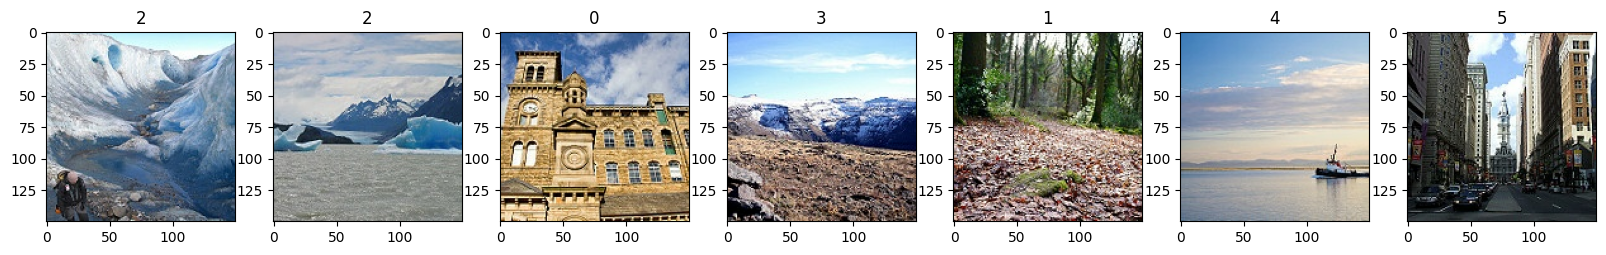

In [ ]:
fig, ax = plt.subplots(ncols=7, figsize=(20,20))
for idx, img in enumerate(batch[0][:7]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

As we can see above the following numbers match the following catagories:
0. building
1. forest
2. glacier
3. mountain
4. sea
5. street

In [15]:
print("max:" , batch[0].max(), " and min: ", batch[0].min())

max: 255.0  and min:  0.0


In [28]:
data = data.map(lambda x, y: (x / 255.0, y))

In [29]:
test = test.map(lambda x, y: (x / 255.0, y))

In [30]:
data.as_numpy_iterator().next()[0].max(), data.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

In [31]:
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.2)

In [32]:
print(train_size, val_size)

88 22


In [33]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

In [34]:
# Number of batches * 32 images
len(train), len(val), len(test)

(88, 22, 24)

In [41]:
model= tf.keras.Sequential([
    # First layer
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Second layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [42]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 17, 17, 64)       

In [8]:
logdir = '/content/drive/MyDrive/IntelClassification/logs'

In [9]:
callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [46]:
history = model.fit(train, epochs=20, validation_data = val, callbacks=[callback])

Epoch 1/20
88/88 [==============================] - 1509s 17s/step - loss: 1.1800 - accuracy: 0.5382 - val_loss: 0.9256 - val_accuracy: 0.6495
Epoch 2/20
88/88 [==============================] - 622s 7s/step - loss: 0.8203 - accuracy: 0.6931 - val_loss: 0.7644 - val_accuracy: 0.7148
Epoch 3/20
88/88 [==============================] - 548s 6s/step - loss: 0.6574 - accuracy: 0.7583 - val_loss: 0.8163 - val_accuracy: 0.6917
Epoch 4/20
88/88 [==============================] - 546s 6s/step - loss: 0.5559 - accuracy: 0.8000 - val_loss: 0.6145 - val_accuracy: 0.7744
Epoch 5/20
88/88 [==============================] - 550s 6s/step - loss: 0.4655 - accuracy: 0.8308 - val_loss: 0.5419 - val_accuracy: 0.8119
Epoch 6/20
88/88 [==============================] - 607s 7s/step - loss: 0.3961 - accuracy: 0.8573 - val_loss: 0.5389 - val_accuracy: 0.8090
Epoch 7/20
88/88 [==============================] - 549s 6s/step - loss: 0.3366 - accuracy: 0.8775 - val_loss: 0.5116 - val_accuracy: 0.8199
Epoch 8/20


In [47]:
model.save('best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the saved model
#loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/IntelClassification/first_model_8epc.h5')

In [ ]:
# Compile the loaded model
#loaded_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Train the loaded model
#history = loaded_model.fit(train_images_norm, train_labels, epochs=8, validation_data=(val_images_norm, val_labels), callbacks=[callback])


In [38]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

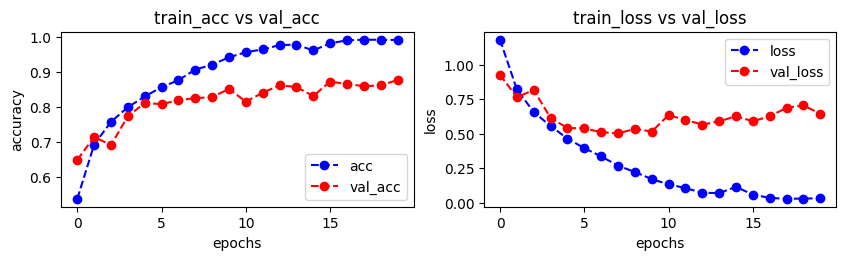

In [49]:
plot_accuracy_loss(history)

In [52]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)

3/3 [==============================] - 1s 204ms/step


In [53]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9672, Recall: 0.9499, Accuracy:0.6667


# VGG Model

In [1]:
from tensorflow.keras.applications import VGG16
model_vgg = VGG16(weights='imagenet', include_top = False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [7]:
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
history_vgg = model_vgg.fit(train, epochs=10, validation_data = val, callbacks=[callback])

Epoch 1/10
88/88 [==============================] - 4231s 49s/step - loss: 1.0840 - accuracy: 0.5823 - val_loss: 0.8714 - val_accuracy: 0.6639
Epoch 2/10
88/88 [==============================] - 597s 7s/step - loss: 0.7180 - accuracy: 0.7392 - val_loss: 0.7871 - val_accuracy: 0.7137
Epoch 3/10
88/88 [==============================] - 567s 6s/step - loss: 0.5998 - accuracy: 0.7805 - val_loss: 0.5671 - val_accuracy: 0.8000
Epoch 4/10
88/88 [==============================] - 566s 6s/step - loss: 0.5072 - accuracy: 0.8203 - val_loss: 0.5446 - val_accuracy: 0.8061
Epoch 5/10
88/88 [==============================] - 566s 6s/step - loss: 0.4128 - accuracy: 0.8521 - val_loss: 0.5334 - val_accuracy: 0.8137
Epoch 6/10
88/88 [==============================] - 562s 6s/step - loss: 0.3311 - accuracy: 0.8843 - val_loss: 0.5057 - val_accuracy: 0.8300
Epoch 7/10
88/88 [==============================] - 555s 6s/step - loss: 0.2692 - accuracy: 0.9090 - val_loss: 0.5036 - val_accuracy: 0.8354
Epoch 8/10


In [41]:
model_vgg.save('vgg_model.h5')

In [ ]:
plt.plot(history_vgg.history["accuracy"])
plt.plot(history_vgg.history['val_accuracy'])
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

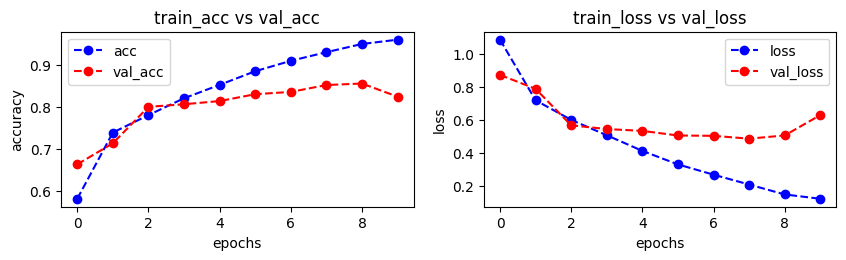

In [39]:
plot_accuracy_loss(history_vgg)

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model_vgg.predict(X, batch_size=128)
    # print(y.shape, yhat.shape)
    # break
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)

1/1 [==============================] - 1s 1s/step


In [ ]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre_test = Precision()
re_test = Recall()
acc_test = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg.predict(X, batch_size=128)
    # print(y.shape, yhat.shape)
    # break
    y_pred = np.argmax(yhat,axis=1)
    pre_test.update_state(y, y_pred)
    re_test.update_state(y, y_pred)
    acc_test.update_state(y, y_pred)

In [31]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)